In [1]:
#加载本次数据处理用到的python库
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot as plt

In [2]:
req_data = pd.read_csv('winemag-data_first150k.csv')
print(req_data.shape)
origin_data = req_data.iloc[:,1:]
print(origin_data.shape)
origin = origin_data.dropna(axis=0, how='any', inplace=False)

print(origin.isnull().sum())
print(origin.shape)

fin_origin = origin.loc[:,['country','designation','points','price','province','region_1','region_2','variety','winery']]
print(fin_origin.shape)
dataset = []
for index, row in fin_origin.iterrows():
    tmp_ds = []
    tmp_ds.append(row[0])
    tmp_ds.append(row[1])
    tmp_ds.append(row[2])
    tmp_ds.append(row[3])
    tmp_ds.append(row[4])
    tmp_ds.append(row[5])
    tmp_ds.append(row[6])
    tmp_ds.append(row[7])
    dataset.append(tmp_ds)

print(len(dataset))

(150930, 11)
(150930, 10)
country        0
description    0
designation    0
points         0
price          0
province       0
region_1       0
region_2       0
variety        0
winery         0
dtype: int64
(39241, 10)
(39241, 9)
39241


In [3]:
def Create_C1(dataset):
    
    C1 = set()
    for piece in dataset:
        for item in piece:
            itemset = frozenset([str(item)])
            C1.add(itemset)
    return C1

def Judge_apriori(Ck_item,Fk_sub_1):
    
    for item in Ck_item:
        sub_item = Ck_item - frozenset([item])
        if sub_item not in Fk_sub_1:
            return False
    return True

def Create_Ck(Fk_sub_1, k):
    
    Ck = set()
    len_Fk_sub_1 = len(Fk_sub_1)
    list_Fk_sub_1 = list(Fk_sub_1)
    
    for i in range(len_Fk_sub_1):
        for j in range(i+1,len_Fk_sub_1):
            list1 = list(list_Fk_sub_1[i])
            list2 = list(list_Fk_sub_1[j])
            list1.sort()
            list2.sort()
            
            if list1[0:k-2] == list2[0:k-2]:
                Ck_item = list_Fk_sub_1[i] | list_Fk_sub_1[j]
                if Judge_apriori(Ck_item, Fk_sub_1):
                    Ck.add(Ck_item)
    return Ck

def Generate_Fk_by_Ck(dataset, Ck, minsup, support_data):
    
    Fk = set()
    item_count = {}
    
    for piece in dataset:
        for Ck_item in Ck:
            if Ck_item.issubset(piece):
                if Ck_item not in item_count:
                    item_count[Ck_item] = 1
                else:
                    item_count[Ck_item] += 1
                    
    data_num = float(len(dataset))
    for item in item_count:
        if( item_count[item] / data_num ) >= minsup:
            Fk.add(item)
            support_data[item] = item_count[item] /data_num
            
    return Fk

def Generate_F(dataset, max_k, minsup):
    
    support_data = {}
    C1 = Create_C1(dataset)
    F1 = Generate_Fk_by_Ck(dataset, C1, minsup, support_data)
    Fk_sub_1 = F1.copy()
    F = []
    
    F.append(Fk_sub_1)
    
    for k in range(2, max_k+1):
        Ck = Create_Ck(Fk_sub_1, k)
        Fk = Generate_Fk_by_Ck(dataset, Ck, minsup, support_data)
        Fk_sub_1 = Fk.copy()
        F.append(Fk_sub_1)
    
    return F, support_data

def Generate_Rule(F, support_data, minconf):
    
    rule_list = []
    subset_list = []
    
    for i in range(len(F)):
        for frequent_set in F[i]:
            for subset in subset_list:
                if subset.issubset(frequent_set):
                    conf = support_data[frequent_set] / support_data[subset]
                    rule = (subset, frequent_set-subset, conf)
                    if conf >= minconf and rule not in rule_list:
                        rule_list.append(rule)
            subset_list.append(frequent_set)
    return rule_list
#通过设定最小支持度和最小置信度，导出关联规则，并计算其支持度和置信度
minsup = 0.05
minconf = 0.75
F, support_data = Generate_F(dataset, 8, minsup)
rule_list = Generate_Rule(F, support_data, minconf)

for Fk in F:
    if len(list(Fk)) == 0:
        continue
    print("-"*80)
    print("Frequent\t"+ str(len(list(Fk)[0])) +"-itemsets\t\tSupport")
    print("-"*80)
    for frequent_set in Fk:
        print(frequent_set, '\t', support_data[frequent_set])
print()
print("Extracted Rules")
for item in rule_list:
    print(item[0], "=>", item[1], "\t\t  conf: ", item[2])

--------------------------------------------------------------------------------
Frequent	1-itemsets		Support
--------------------------------------------------------------------------------
frozenset({'Cabernet Sauvignon'}) 	 0.12476746260288983
frozenset({'US'}) 	 1.0
frozenset({'Willamette Valley'}) 	 0.060778267628245966
frozenset({'Paso Robles'}) 	 0.05338803802145715
frozenset({'Napa Valley'}) 	 0.08944726179251293
frozenset({'Chardonnay'}) 	 0.1247419790525216
frozenset({'Syrah'}) 	 0.07168522718585153
frozenset({'Pinot Noir'}) 	 0.19000535154557732
frozenset({'Oregon'}) 	 0.07739354246833668
frozenset({'Sonoma'}) 	 0.19841492316709564
frozenset({'Central Coast'}) 	 0.2331744858693713
frozenset({'Russian River Valley'}) 	 0.06702173746846411
frozenset({'Napa'}) 	 0.13016997528095614
frozenset({'Columbia Valley (WA)'}) 	 0.07346907571162814
frozenset({'Washington'}) 	 0.15601029535434877
frozenset({'Zinfandel'}) 	 0.0719400626895339
frozenset({'Columbia Valley'}) 	 0.147422338880

In [9]:
confs = []
kulcs = []
lifts = []
irs = []

for item in rule_list:
    x = support_data[item[0]]
    y = support_data[item[1]]
    x_to_y = item[2]
    kulc = 0.5*(x_to_y/x+x_to_y/y)
    ir = abs(x - y)/(x+y-x_to_y)
    
    confs.append(x_to_y)
    kulcs.append(kulc)
    lifts.append(float( x_to_y/y ))
    irs.append(ir)
    print(item[0], "=>", item[1], " lift: ", float( x_to_y/y ), "  kulc: ", kulc," IR: ",ir)

frozenset({'Chardonnay'}) => frozenset({'US'})  lift:  1.0   kulc:  4.5082737487231865  IR:  7.01654749744638
frozenset({'Pinot Noir'}) => frozenset({'US'})  lift:  1.0   kulc:  3.13150482832618  IR:  4.263009656652361
frozenset({'Russian River Valley'}) => frozenset({'Sonoma'})  lift:  5.039943488312356   kulc:  9.980237903851995  IR:  -0.17887250650477016
frozenset({'Paso Robles'}) => frozenset({'US'})  lift:  1.0   kulc:  9.865393794749403  IR:  17.730787589498828
frozenset({'Napa'}) => frozenset({'US'})  lift:  1.0   kulc:  4.341131558339859  IR:  6.682263116679715
frozenset({'California'}) => frozenset({'US'})  lift:  1.0   kulc:  1.187064467556116  IR:  0.3741289351122317
frozenset({'Willamette Valley'}) => frozenset({'US'})  lift:  1.0   kulc:  8.726624737945492  IR:  15.453249475890974
frozenset({'Washington'}) => frozenset({'Columbia Valley'})  lift:  6.409833387781771   kulc:  6.233411152263766  IR:  -0.013386888222759463
frozenset({'Columbia Valley'}) => frozenset({'Washingt

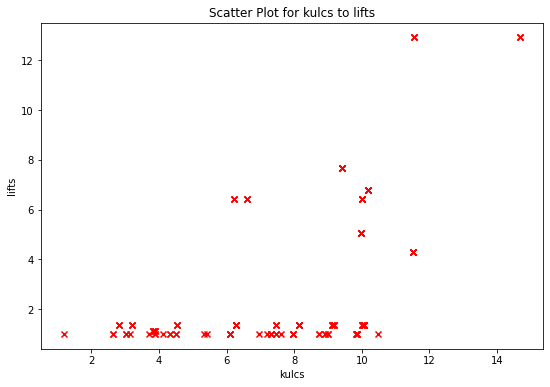

In [10]:
#可视化结果，观察kulc，lift和IR间的分布影响。
import numpy as np
import matplotlib.pyplot as plt

x = kulcs
y = lifts

fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)
ax1.set_title('Scatter Plot for kulcs to lifts')

plt.xlabel('kulcs')
plt.ylabel('lifts')
ax1.scatter(x,y,c = 'r',marker = 'x')

plt.show()

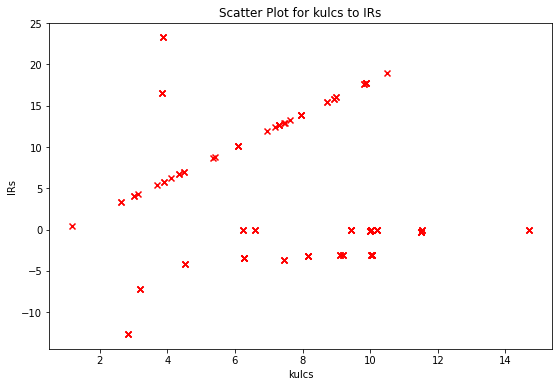

In [11]:
x = kulcs
y = irs

fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)

ax1.set_title('Scatter Plot for kulcs to IRs')
plt.xlabel('kulcs')
plt.ylabel('IRs')

ax1.scatter(x,y,c = 'r',marker = 'x')
plt.show()